## 3. Model - AutoRegressive Integrated Moving Average (ARIMA)

In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf 
import matplotlib.dates as mdates 
import matplotlib.pyplot as plt 
from pmdarima.arima import auto_arima 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
%matplotlib inline 
plt.style.use('seaborn-v0_8-dark') 
import warnings
warnings.filterwarnings('ignore')   

#### 1. Fetching Data

In [2]:
start_date = '2018-01-01'
end_date = '2019-09-01' 

assets = 'BTC-USD' 

In [3]:
btc_adjClose = pd.DataFrame() 

btc_adjClose['Adj_Close'] = yf.download('BTC-USD',start=start_date,end=end_date)['Adj Close']  

[*********************100%%**********************]  1 of 1 completed


In [4]:
btc_adjClose['Returns'] = btc_adjClose['Adj_Close'].pct_change(1)
btc_adjClose.dropna(inplace=True)
btc_adjClose.head() 

,Adj_Close,Returns
Date,,
2018-01-02,14982.099609,0.097011
2018-01-03,15201.000000,0.014611
2018-01-04,15599.200195,0.026196
2018-01-05,17429.500000,0.117333
2018-01-06,17527.000000,0.005594


#### 2. ACF and PACF for BITCOIN Returns

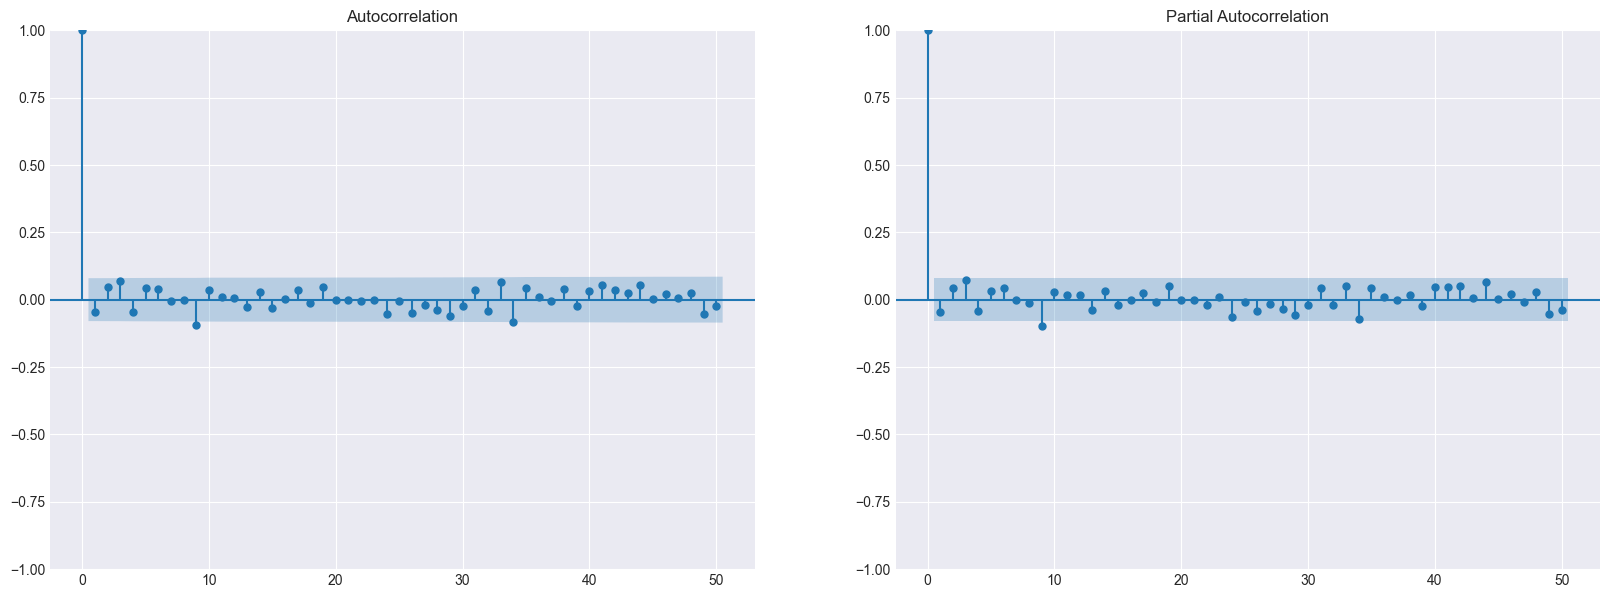

In [5]:
fig, axs = plt.subplots(1,2,figsize=(20,7)) 

plot_acf(btc_adjClose['Returns'], lags=50, ax=axs[0])
axs[0].grid(True)

plot_pacf(btc_adjClose['Returns'], lags=50, ax=axs[1])
axs[1].grid(True)

plt.show() 

#### 3. ACF and PACF for Squared BITCOIN Returns

In [6]:
BTC_RET_SQ = btc_adjClose['Returns']**2 
BTC_RET_SQ.head() 

Date
2018-01-02    0.009411
2018-01-03    0.000213
2018-01-04    0.000686
2018-01-05    0.013767
2018-01-06    0.000031
Name: Returns, dtype: float64

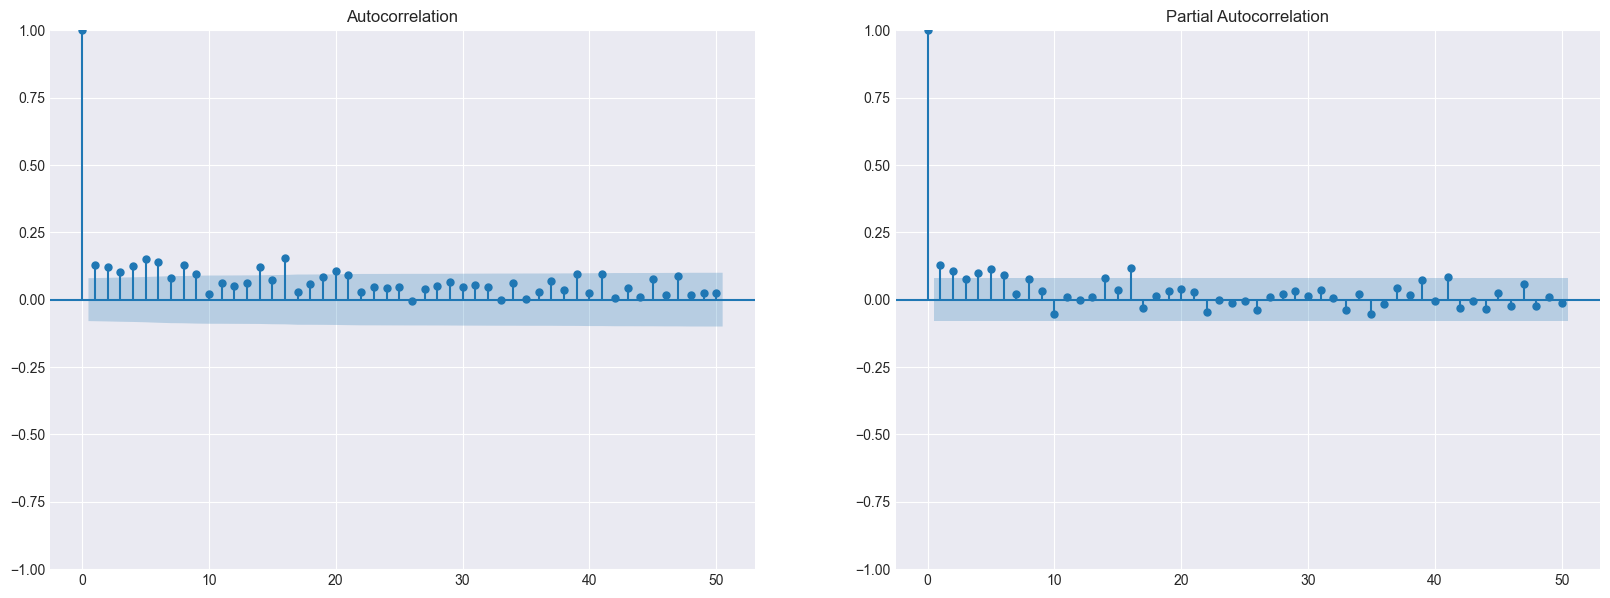

In [7]:
fig, axs = plt.subplots(1,2,figsize=(20,7)) 

plot_acf(BTC_RET_SQ, lags=50, ax=axs[0])
axs[0].grid(True)

plot_pacf(BTC_RET_SQ, lags=50, ax=axs[1])
axs[1].grid(True)

plt.show() 

#### 4. Splitting data into training and testing dataset

In [8]:
btc_split = btc_adjClose['Adj_Close']

btc_train = btc_split[:487] 
btc_test = btc_split[486:] 

print(f'Shape of train after splitting : {btc_train.shape}') 
print(f'Shape of test after splitting : {btc_test.shape}')  

Shape of train after splitting : (487,)
Shape of test after splitting : (121,)


### 5. Defining the ARIMA Model

In [9]:
B_model = auto_arima(btc_train,start_p=0,start_q=0,max_p=3,max_q=3,m=12,start_P=0,seasonal=True,d=1,D=1,trace=True,error_action='ignore',suppress_warnings=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7177.307, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7042.262, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7178.115, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=6972.964, Time=0.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=6971.266, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=7040.879, Time=0.13 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6972.993, Time=0.40 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=6974.123, Time=1.22 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=6973.0

In [10]:
B_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  487
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -3482.633
Date:                            Mon, 15 Jul 2024   AIC                           6971.266
Time:                                    23:46:20   BIC                           6983.749
Sample:                                01-02-2018   HQIC                          6976.175
                                     - 05-03-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7170      0.023    -30.623      0.000      -0.763      -0.671
ar.S.L24      -0.4263      0.024    -17.405      0.000      -0.474      -0.378
sigma2       1.36e+05   4687.688     29.004      0.000    1.27e+05    1.45e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               884.70
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 6. Training the Model

In [11]:
B_model.fit(btc_train)  

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

#### 7. Predictions using trained model

In [12]:
forecast = B_model.predict(n_periods=120) 
forecast = pd.DataFrame(forecast,index=btc_test.index,columns=['Prediction']) 

#### 8. Evaluating the predictions

In [13]:
btc_test = btc_test.to_frame()  
df = forecast.join(btc_test) 
df.dropna(inplace=True)
df.head() 

,Prediction,Adj_Close
Date,,
2019-05-04,5839.544172,5831.167480
2019-05-05,5816.409192,5795.708496
2019-05-06,5792.740755,5746.807129
2019-05-07,5745.315976,5829.501465
2019-05-08,6093.112581,5982.457520


In [14]:
# RMSE for ARIMA 

rmse = np.sqrt(np.mean(np.power((np.array(df['Adj_Close'])-np.array(df['Prediction'])),2))) 
print(f'RMSE for ARIMA : {rmse:.6f}')  

# MAPE for ARIMA 

mape = np.mean(np.abs(df['Prediction']-df['Adj_Close'])/np.abs(df['Adj_Close'])) 
print(f'MAPE for ARIMA : {mape:.6f}')  

# MPE for ARIMA

mpe = np.mean((df['Prediction'].dropna().values-df['Adj_Close'].dropna().values)/df['Adj_Close'].dropna().values) 
print(f'MPE for ARIMA : {mpe:.6f}') 

RMSE for ARIMA : 1869.861351
MAPE for ARIMA : 0.148837
MPE for ARIMA : -0.141775


#### 9. Correlation between actual values and predicted via ARIMA

In [15]:
corr_ARIMA = np.corrcoef(df['Prediction'].dropna().values,df['Adj_Close'].dropna().values)[0,1] 
print(f'Correlation between test_Close and ARIMA Predictions : {corr_ARIMA*100:.2f}%')  

Correlation between test_Close and ARIMA Predictions : 70.77%


#### 10. Plotting the predictions from ARIMA w.r.t Test values

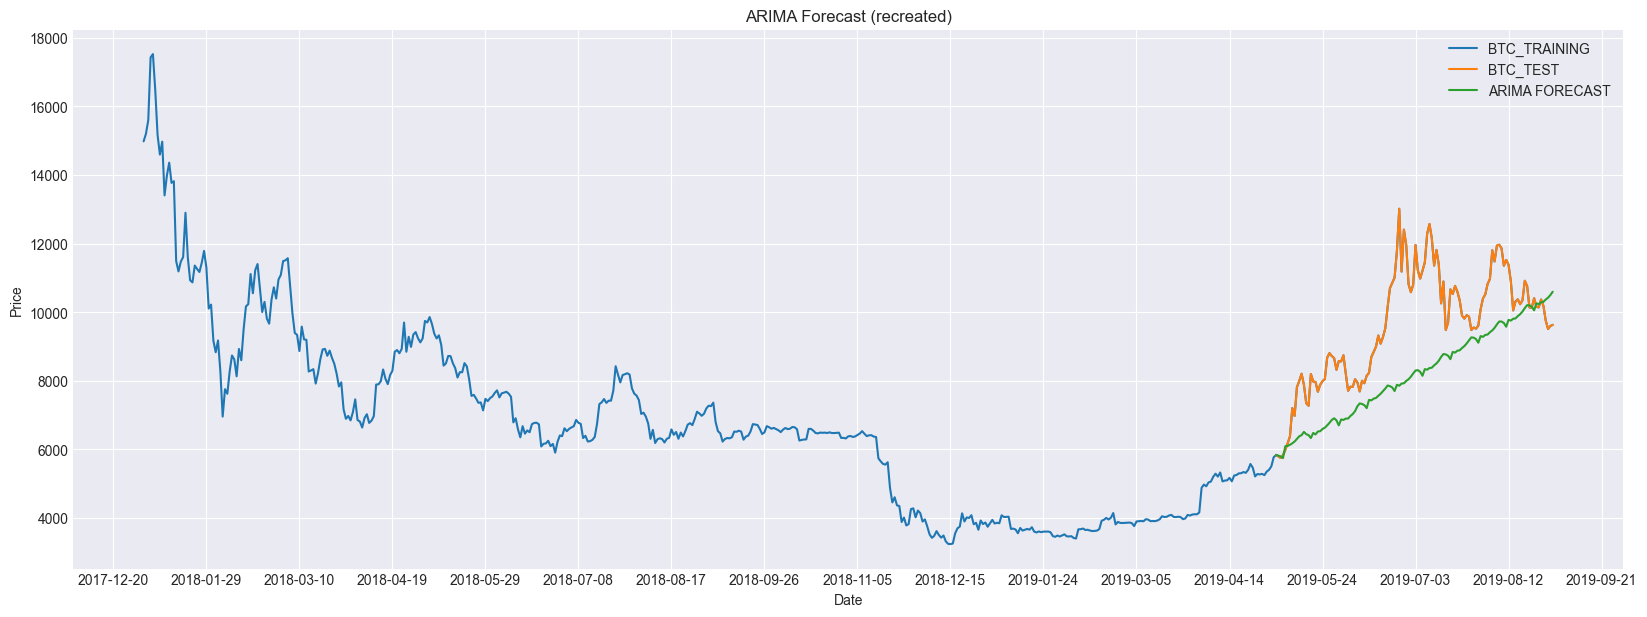

In [16]:
plt.figure(figsize=(20,7)) 
ax = plt.axes() 
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) 
plt.plot(btc_adjClose['Adj_Close'],label='BTC_TRAINING') 
plt.plot(df['Adj_Close'],label='BTC_TEST') 
plt.plot(df['Prediction'],label='ARIMA FORECAST') 
plt.xlabel('Date') 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.title('ARIMA Forecast (recreated)') 
plt.ylabel('Price') 
ax.grid(True) 
plt.legend(loc='best') 
plt.show() 